# A Random Forest Predictive Algorithm of Australian Quarterly Inflation

In [890]:
from pandas_datareader import data
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller

### Importing the Data

first we import the data output from our r code as well as an excel sheet covering unemployment and CPI variables.
We then merge the data frames together. 

In [940]:
df = pd.read_excel (r'C:\Users\bened\Documents\features_short.xlsx')
df

df_CPI = pd.read_excel(r'C:\Users\bened\Documents\CPI time series.xls', 'Sheet1')
df_CPI

df_unemployment_variables = pd.read_excel(r'C:\Users\bened\Documents\Urate sheet.xls', 'Sheet1')


df = pd.merge(df, df_CPI)
df = pd.merge(df, df_unemployment_variables)

df = df.iloc[1: , :]
df = df.dropna(axis=1)
df

,date,residential index,Percentage change from previous quarter ; Final ; Total (Source) ;,Index Number ; Coal mining ;,Percentage change from previous quarter ; Coal mining ;,Percentage change from corresponding quarter of previous year ; Coal mining ;,Index Numbers ; Manufacturing division ;,Index Numbers ; Imported materials ;,Index Numbers ; Domestic materials ;,Index Numbers ; Manufact. div. less petroleum ;,...,Percentage Change from Previous Period ; All groups CPI ; Adelaide ;,Percentage Change from Previous Period ; All groups CPI ; Perth ;,Percentage Change from Previous Period ; All groups CPI ; Hobart ;,Percentage Change from Previous Period ; All groups CPI ; Darwin ;,Percentage Change from Previous Period ; All groups CPI ; Canberra ;,Percentage Change from Previous Period ; All groups CPI ; Australia ;,Unemployment rate ; Persons ;,Underemployment ratio (proportion of employed) ; Persons ;,Long-term unemployment ratio ; Persons ;,Average duration of job search ; Persons ;
1,1998-12-01,70.9,-0.6,57.8,-0.2,-1.0,65.9,82.6,60.7,70.0,...,0.4,0.4,0.0,0.3,0.3,0.4,7.184215,7.301908,31.016858,53.097776
2,1999-03-01,70.7,-0.3,57.5,-0.5,-2.2,64.9,81.4,59.8,69.3,...,-0.7,-0.4,-0.4,-0.4,-0.1,0.0,7.013355,7.098038,29.516246,50.774769
3,1999-06-01,70.9,0.3,58.1,1.0,1.8,64.7,79.9,60.0,68.4,...,0.7,0.9,0.3,0.6,0.0,0.4,6.654351,7.409522,28.322961,51.215036
4,1999-09-01,71.5,0.8,58.2,0.2,0.5,65.1,79.1,60.9,67.8,...,1.2,0.9,0.6,0.1,0.9,0.9,7.042515,6.542792,27.446670,50.429977
5,1999-12-01,72.1,0.8,60.3,3.6,4.3,67.3,80.6,63.4,69.4,...,0.6,0.6,0.6,0.6,0.9,0.6,6.685201,6.810681,26.404235,48.393350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2020-06-01,111.2,-1.2,106.3,-3.1,-2.3,114.5,114.8,116.1,120.5,...,-1.0,-1.2,-1.4,-2.5,-2.3,-1.9,7.357104,12.570985,15.492546,33.986719
88,2020-09-01,111.7,0.4,107.3,0.9,-1.6,114.7,116.0,115.8,119.8,...,1.0,1.8,1.0,1.7,2.3,1.6,6.855995,12.257528,20.173643,43.743553
89,2020-12-01,112.3,0.5,107.0,-0.3,-2.4,115.1,115.3,116.7,120.3,...,0.7,-1.0,0.8,0.6,0.8,0.9,6.585224,9.133499,21.934226,47.644845
90,2021-03-01,112.8,0.4,107.6,0.6,-1.9,117.6,118.5,119.0,121.8,...,0.6,1.4,0.8,2.6,0.9,0.6,5.696900,8.431537,30.888857,53.243938


### Stationarity 

Stationarity is important for ensuring out of sample model performance. If our model learns in a non-stationary envionment it will struggle to generalise into the future. This is because the fundamental relationships between the variables and the target (by definition) evolve over time - the algorithm will learn off the time period of the training set failing in the future when the relationships between features and the target evolves. 

We now go through the process of checking whether variables are stationary, and making stationary time series if they're not. We first use the augmented dicky fuller test to filter any variables that are already stationary and put them to the side. We are then left with the non-stationary variables - we difference these variables adn test if this is then stationary. If it is we put these variables to the side. This process is repeated until we have multiple dataframes of stationary variables that we will amalgamate for further analysis. 

In [941]:
df = df.dropna()
stationary_columns = []
stationary_columns_index = []
for column in df.iloc[:,1:]:
    ad_column = df[str(column)].values
    column_index = df.columns.get_loc(str(column))
    result = adfuller(ad_column)
    if result[1] <= 0.05:
        
        stationary_columns.append(column)
        stationary_columns_index.append(column_index)
len(stationary_columns_index) #number of columns that are already stationary ~35%
stationary_columns_index

df_stationary = df[stationary_columns]

df_stationary['date'] = df['date'].copy()
df_stationary = df_stationary.set_index('date')
df_not_stationary = df.drop(columns = stationary_columns)
# df_not_stationary2 = df_not_stationary
# df_stationary

<ipython-input-941-720b264cd48d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stationary['date'] = df['date'].copy()


In [942]:
df_not_stationary.iloc[:,1:] = df_not_stationary.iloc[:,1:] - df_not_stationary.iloc[:,1:].shift(1)
df_not_stationary.isnull().sum()
df_not_stationary = df_not_stationary.dropna(axis=0)
# df_not_stationary

In [943]:
stationary_columns2 = []
stationary_columns_index2 = []
for column in df_not_stationary.iloc[:,1:]:
    ad_column = df_not_stationary[str(column)].values
    column_index = df_not_stationary.columns.get_loc(str(column))
    result = adfuller(ad_column)
    if result[1] < 0.05:
        stationary_columns2.append(column)
        stationary_columns_index2.append(column_index)
        count = count +1

        df_stationary2 = df_not_stationary[stationary_columns2]
df_not_stationary = df_not_stationary.drop((stationary_columns2), axis =1)

df_stationary2['date'] = df_not_stationary['date'].copy()
df_stationary2 = df_stationary2.set_index('date')
# df_not_stationary

In [944]:
df_not_stationary.iloc[:,1:] = df_not_stationary.iloc[:,1:].diff()
df_not_stationary = df_not_stationary.dropna(axis=0)
# df_not_stationary

In [945]:
stationary_columns3 = []
stationary_columns_index3 = []

for column in df_not_stationary.iloc[:,1:]:
    ad_column = df_not_stationary[str(column)].values
    column_index = df_not_stationary.columns.get_loc(str(column))
    result = adfuller(ad_column)
    if result[1] < 0.05:
        stationary_columns3.append(column)
        stationary_columns_index3.append(column_index)

        df_stationary3 = df_not_stationary[stationary_columns3]

df_not_stationary = df_not_stationary.drop((stationary_columns3), axis =1)
df_stationary3['date'] = df_not_stationary['date'].copy()
df_stationary3 = df_stationary3.set_index('date')
# df_stationary3

We now have 3 dataframes of stationary variables -we will merge these together for further analysis.

In [946]:
df2 = pd.merge(df_stationary3, df_stationary2, left_index=True, right_index=True)
df3 = pd.merge(df2, df_stationary, left_index=True, right_index=True)
df_now = df3.tail(1)
df3

,Index Numbers ; Agriculture ;,Index Numbers ; Metal ore mining ;,GDP per capita: Chain volume measures ;,Gross domestic product: Current prices ;,GDP per hour worked: Index ;,Gross value added per hour worked market sector: Index ;,Current account ;,Services ;,Capital and financial account ;,"Value of data item ; Assets, Loans, residential mortgages ;",...,Total Employees Involved ; Quarter ; Dispute occurred ;,Percentage Change from Previous Period ; All groups CPI ; Sydney ;,Percentage Change from Previous Period ; All groups CPI ; Melbourne ;,Percentage Change from Previous Period ; All groups CPI ; Brisbane ;,Percentage Change from Previous Period ; All groups CPI ; Perth ;,Percentage Change from Previous Period ; All groups CPI ; Hobart ;,Percentage Change from Previous Period ; All groups CPI ; Darwin ;,Percentage Change from Previous Period ; All groups CPI ; Canberra ;,Percentage Change from Previous Period ; All groups CPI ; Australia ;,Unemployment rate ; Persons ;
date,,,,,,,,,,,,,,,,,,,,,
1999-06-01,-2.6,0.4,1546.0,16581.0,8.9,8.1,453.0,-975.0,121.0,1340.0,...,51.3,0.4,0.4,0.3,0.9,0.3,0.6,0.0,0.4,6.654351
1999-09-01,-0.5,-0.2,-107.0,-1794.0,-1.1,-0.6,-511.0,8.0,970.0,1945.0,...,265.1,0.9,1.0,0.8,0.9,0.6,0.1,0.9,0.9,7.042515
1999-12-01,2.2,3.2,539.0,7413.0,1.8,1.7,4245.0,891.0,-5712.0,-2543.0,...,118.1,0.6,0.6,0.0,0.6,0.6,0.6,0.9,0.6,6.685201
2000-03-01,-0.5,-2.0,-1757.0,-18569.0,-8.0,-8.4,-3479.0,-144.0,4383.0,3648.0,...,105.5,0.9,1.1,1.2,0.4,1.0,0.6,1.0,0.9,6.565782
2000-06-01,0.2,0.7,1365.0,13515.0,7.3,7.7,-193.0,-1352.0,-257.0,-3526.0,...,129.2,0.9,0.6,0.6,0.7,1.0,1.1,0.9,0.7,6.116051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,-2.8,-2.2,1001.0,17894.0,13.7,15.5,3342.0,-86.0,-4211.0,-4545.0,...,1.1,-2.3,-1.8,-2.2,-1.2,-1.4,-2.5,-2.3,-1.9,7.357104
2020-09-01,-8.3,3.4,1033.0,31849.0,-7.2,-9.9,-21618.0,-2177.0,19763.0,310.0,...,4.3,1.8,0.9,2.3,1.8,1.0,1.7,2.3,1.6,6.855995
2020-12-01,4.7,-5.4,899.0,27595.0,3.4,6.3,17866.0,-175.0,-17557.0,-1128.0,...,2.6,1.0,1.5,1.1,-1.0,0.8,0.6,0.8,0.9,6.585224


### Importing the Target variable and final cleaning

The target is the next periods Quarterly change in inflation as measured by the CPI. We input this variable and join it to our dataframe of stationary variables. 


In [929]:
df4 = pd.DataFrame(df_CPI['Percentage Change from Previous Period ;  All groups CPI ;  Australia ;'].shift(-1).copy())
df4.rename(columns = {'Percentage Change from Previous Period ;  All groups CPI ;  Australia ;': 'target'}, inplace = True)
df4['date'] = df_CPI['date'].copy()

In [930]:
df4 = df4.set_index('date')
df3 = pd.merge(df3, df4, left_index=True, right_index=True)
df3 = df3.dropna()
df3

,Index Numbers ; Agriculture ;,Index Numbers ; Metal ore mining ;,GDP per capita: Chain volume measures ;,Gross domestic product: Current prices ;,GDP per hour worked: Index ;,Gross value added per hour worked market sector: Index ;,Current account ;,Services ;,Capital and financial account ;,"Value of data item ; Assets, Loans, residential mortgages ;",...,Percentage Change from Previous Period ; All groups CPI ; Sydney ;,Percentage Change from Previous Period ; All groups CPI ; Melbourne ;,Percentage Change from Previous Period ; All groups CPI ; Brisbane ;,Percentage Change from Previous Period ; All groups CPI ; Perth ;,Percentage Change from Previous Period ; All groups CPI ; Hobart ;,Percentage Change from Previous Period ; All groups CPI ; Darwin ;,Percentage Change from Previous Period ; All groups CPI ; Canberra ;,Percentage Change from Previous Period ; All groups CPI ; Australia ;,Unemployment rate ; Persons ;,target
date,,,,,,,,,,,,,,,,,,,,,
1999-06-01,-2.6,0.4,1546.0,16581.0,8.9,8.1,453.0,-975.0,121.0,1340.0,...,0.4,0.4,0.3,0.9,0.3,0.6,0.0,0.4,6.654351,0.9
1999-09-01,-0.5,-0.2,-107.0,-1794.0,-1.1,-0.6,-511.0,8.0,970.0,1945.0,...,0.9,1.0,0.8,0.9,0.6,0.1,0.9,0.9,7.042515,0.6
1999-12-01,2.2,3.2,539.0,7413.0,1.8,1.7,4245.0,891.0,-5712.0,-2543.0,...,0.6,0.6,0.0,0.6,0.6,0.6,0.9,0.6,6.685201,0.9
2000-03-01,-0.5,-2.0,-1757.0,-18569.0,-8.0,-8.4,-3479.0,-144.0,4383.0,3648.0,...,0.9,1.1,1.2,0.4,1.0,0.6,1.0,0.9,6.565782,0.7
2000-06-01,0.2,0.7,1365.0,13515.0,7.3,7.7,-193.0,-1352.0,-257.0,-3526.0,...,0.9,0.6,0.6,0.7,1.0,1.1,0.9,0.7,6.116051,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01,9.0,12.0,-2277.0,-54196.0,-9.8,-10.0,8345.0,-320.0,-2730.0,-4143.0,...,0.3,0.8,-0.1,0.4,0.4,0.3,0.4,0.3,5.274256,-1.9
2020-06-01,-2.8,-2.2,1001.0,17894.0,13.7,15.5,3342.0,-86.0,-4211.0,-4545.0,...,-2.3,-1.8,-2.2,-1.2,-1.4,-2.5,-2.3,-1.9,7.357104,1.6
2020-09-01,-8.3,3.4,1033.0,31849.0,-7.2,-9.9,-21618.0,-2177.0,19763.0,310.0,...,1.8,0.9,2.3,1.8,1.0,1.7,2.3,1.6,6.855995,0.9


## Building the Random Forest Regression Model

We start by splitting the dataframe into a training and testing set. this is done randomly over the data with 20% of data saved for later testing (the algorithm cant see or learn of these observations). 

In [931]:
#Store the data in the form of dependent and independent variables separately
X = df3.iloc[:, df3.columns !='target']
y = df3.loc[:,'target']

#Split the Dataset into Training and Test Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [932]:
#Import the Random Forest Regressor 
from sklearn.ensemble import RandomForestRegressor   
  
#Create a Random Forest regressor object from Random Forest Regressor class
RFReg = RandomForestRegressor(n_estimators = 1000, random_state = 1)
  
#Fit the random forest regressor with training data represented by X_train and y_train
RFReg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [933]:
#Predicted values
y_predict_test_rfr = RFReg.predict((X_test))
y_predict_rfr = RFReg.predict((X_train))

### Model evaluation

 we now test the model on both the training set and the out of sample test set. A large discrepency between these results would imply overfitting. Poor performance on the train set would imply the model has not learned. 

In [934]:
MSE_train = metrics.mean_squared_error(y_train, y_predict_rfr)
MSE_test = metrics.mean_squared_error(y_test, y_predict_test_rfr)

print('MSE Training Error of the Random Forest Regression is:', MSE_train)
print('MSE Testing Error of the Random Forest Regression is:',MSE_test)

MSE Training Error of the Random Forest Regression is: 0.06665267885714296
MSE Testing Error of the Random Forest Regression is: 0.10973506944444412


In [935]:
#Error if you guessed last periods inflation - no change of inflation every period. 
martingale_error = df3['target'].abs()
martingale_error_mean = martingale_error.mean()

#error if you just guessed the average quarterly change in inflation every period 
simple_model_error = (df3['target'].mean() - df3['target'])**2
simple_model_error = simple_model_error.mean()
simple_model_error

0.3386776859504134

Here we test to see if the model performs better than two niave models

1. that predicts the change in inflation will be 0 (predicts inflation is the inflation of the previous period); and

2. that predicts the change in inflation will be the observed average change of inflation. The model beats both these (low bars), providing further evidence that it is learning. 

In [936]:
alpha = MSE_test - martingale_error_mean
print(alpha)
alpha2 = MSE_test - simple_model_error
alpha2

-0.5834467487373742


-0.2289426165059693

for fun we predict what the model thinks the change in inflation will be next period (in the future, abs to release data on 27th of October).

In [938]:
df_now = np.array(df_now).reshape(1, -1)
RFReg.predict(df_now)

array([1.0542])

### Feature Importance

Here we test what variables the model thinks are most improtant for predicting the change in quarterly inflation -for an idea of relative importance, note that total feature importance sums to 1. 

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

This importance metric is biased when predictor variables are highly correlated (with eachother or important unobserved variables), leading to suboptimal predictor variables being artificially preferred - similar to multicollinearity and endogeniety issues in multiple linear reggression. 

Note: the algorithm appears to measure impurity by MSE (source was stack overflow, I couldnt see it clearly in the source code) - https://stackoverflow.com/questions/32083289/feature-importance-results-differ-in-r-and-sklearn-random-forest-regression 

Text(0.5, 1.0, 'Top 10 Most Important Features by Gini Impurity')

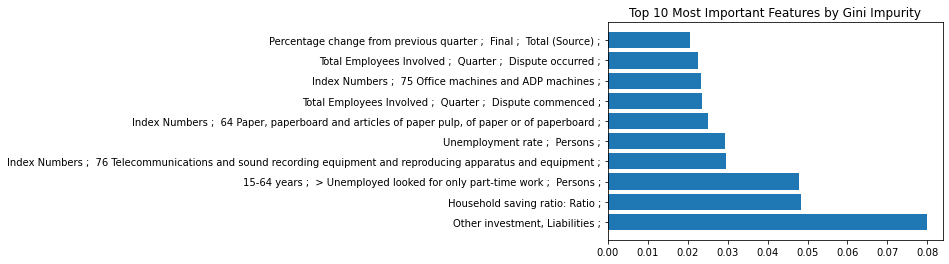

In [949]:
RFReg.feature_importances_
feature_importance = pd.DataFrame({'Features': X.columns,'Gini': RFReg.feature_importances_})
feature_importance = feature_importance.sort_values(by = 'Gini', axis = 0, ascending = False)
feature_importance 
feature_importance_graph = feature_importance.iloc[0:10 , :]
feature_importance_graph
plt.barh( feature_importance_graph['Features'], feature_importance_graph['Gini'])
plt.title('Top 10 Most Important Features by Gini Impurity')

## Phillip's Curve Simulation

We now attempt to tease out the Model's implied Phillip's Curve through simulating different unemployment rates whilst holding all other variables constant - (as at March 2021), and then using the Model's prediction of inflation. 

In [908]:
X.columns.get_loc('Unemployment rate ;  Persons ;')

208

In [909]:
 X.shape

(88, 209)

In [910]:
NAIRU_test = X.iloc[87,:]
NAIRU_test = pd.DataFrame(NAIRU_test)
NAIRU_test = NAIRU_test.transpose()
NAIRU_test 
NAIRU_test2 = pd.DataFrame(np.repeat(NAIRU_test.values,1000,axis=0))
NAIRU_test2.columns = NAIRU_test.columns
# NAIRU_test2

In [911]:
for i in range(len(NAIRU_test2.index)):
    if i != 0:
        NAIRU_test2.iloc[i,208] = 4.5 + np.random.uniform(-1,1)
NAIRU_test2
NAIRU_test2_predictions = RFReg.predict(NAIRU_test2)

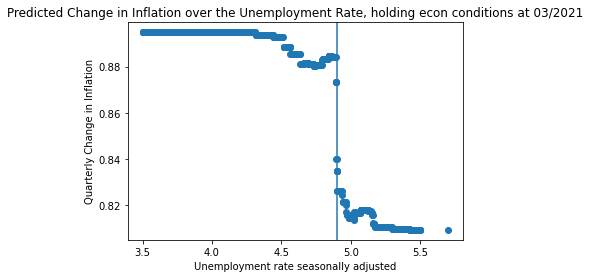

In [912]:
plt.scatter(NAIRU_test2.iloc[:,208],NAIRU_test2_predictions) 
plt.title('Predicted Change in Inflation over the Unemployment Rate, holding econ conditions at 03/2021')
plt.ylabel('Quarterly Change in Inflation')
plt.xlabel('Unemployment rate seasonally adjusted')
plt.axvline(x=4.9)